# Week 1: Linear Regression

---

## Objectives

- Load and inspect the dataset  
- Fit a simple linear regression  
- Create polynomial and interaction terms  
- Diagnose multicollinearity via Variance Inflation Factor (VIF)  
- Handle continuous and categorical predictors in one model  

---

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

## Load the Data

In [2]:
# Load the DData
df = pd.read_csv('datasets/drsufi.csv')

# Parse AttackDate as day/month/year hour:minute
df['AttackDate'] = pd.to_datetime(
    df['AttackDate'],
    format='%d/%m/%Y %H:%M'
)

# Preview
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38834 entries, 0 to 38833
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   AttackDate            38834 non-null  datetime64[ns]
 1   Country               38834 non-null  object        
 2   Spam                  38834 non-null  float64       
 3   Ransomware            38834 non-null  float64       
 4   Local Infection       38834 non-null  float64       
 5   Exploit               38834 non-null  float64       
 6   Malicious Mail        38834 non-null  float64       
 7   Network Attack        38834 non-null  float64       
 8   On Demand Scan        38834 non-null  float64       
 9   Web Threat            38834 non-null  float64       
 10  Rank Spam             38834 non-null  int64         
 11  Rank Ransomware       38834 non-null  int64         
 12  Rank Local Infection  38834 non-null  int64         
 13  Rank Exploit    

## Train/Test Split

In [3]:
X = df[['Ransomware']].values
y = df['Spam'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


## Model Evaluation and Diagnostics
---

## Simple Linear Regression

We will predict `Spam` from `Ransomware` using the following model:

We model

$$
\mathbf y = X\,\boldsymbol\beta + \boldsymbol\epsilon,
$$

where $X$ is the $n\times 2$ design matrix (a column of 1’s and a column of Ransomware values), and

$$
y_i = \beta_0 + \beta_1\,x_i + \epsilon_i
$$

for each observation $i$. Here we assume $\epsilon_i$ are iid with $\mathbb{E}[\epsilon_i]=0$ and $\text{Var} [\epsilon_i]=\sigma^2$.


This makes clear that $\beta_0$ is the intercept and $\beta_1$ the slope on our predictor.

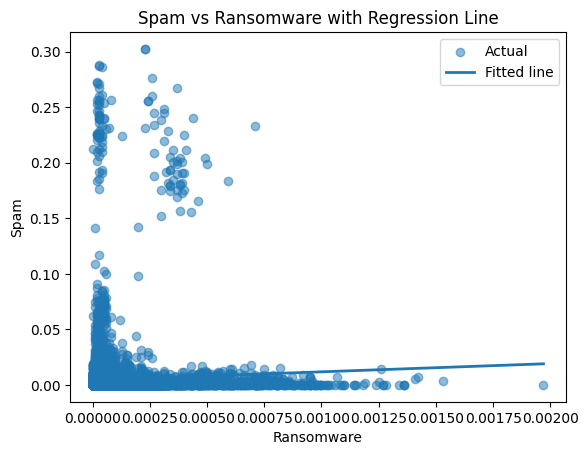

In [4]:
# Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Flatten for plotting
x_test = X_test.ravel()

# Plot data and fitted regression line
idx = np.argsort(x_test)
plt.figure()
plt.scatter(x_test, y_test, alpha=0.5, label='Actual')
plt.plot(x_test[idx], y_pred[idx], linewidth=2, label='Fitted line')
plt.xlabel('Ransomware')
plt.ylabel('Spam')
plt.title('Spam vs Ransomware with Regression Line')
plt.legend()
plt.show()

### Performance Metrics

R^2 = 0.003, MSE = 0.000520


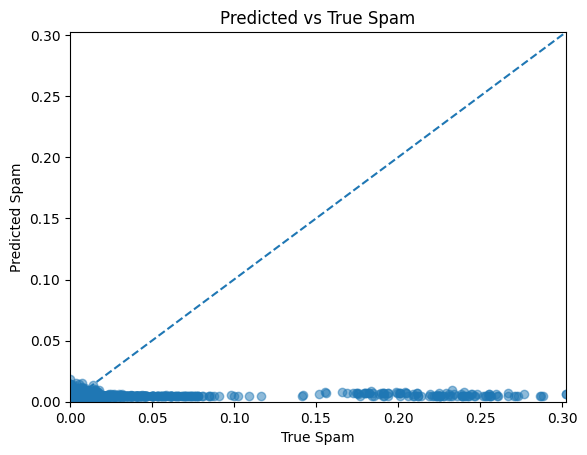

In [5]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R^2 = {r2:.3f}, MSE = {mse:.6f}")

mn = min(y_test.min(), y_pred.min())
mx = max(y_test.max(), y_pred.max())

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlim(mn, mx)
plt.ylim(mn, mx)
plt.xlabel('True Spam')
plt.ylabel('Predicted Spam')
plt.title('Predicted vs True Spam')
plt.show()

### Residual Analysis

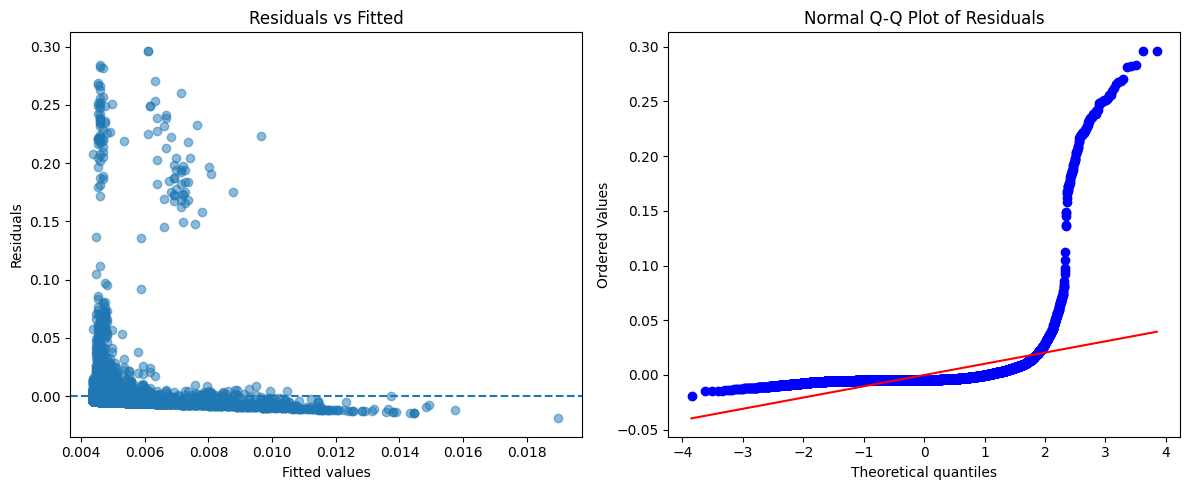

In [6]:
residuals = y_test - y_pred

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Residuals vs Fitted
axes[0].scatter(y_pred, residuals, alpha=0.5)
axes[0].axhline(0, linestyle='--')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted')

# Normal Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

### OLS Summary

In [7]:
X2 = sm.add_constant(df[['Ransomware']])
ols = sm.OLS(df['Spam'], X2).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   Spam   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     102.0
Date:                Fri, 27 Jun 2025   Prob (F-statistic):           5.84e-24
Time:                        13:07:30   Log-Likelihood:                 91090.
No. Observations:               38834   AIC:                        -1.822e+05
Df Residuals:                   38832   BIC:                        -1.822e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.000     31.982      0.0

---
## Multiple Linear Regression

We will predict `Spam` from several threat metrics using the model

$$
\mathbf y = X\,\boldsymbol\beta + \boldsymbol\epsilon,
$$

where $X$ is the $n\times p$ design matrix with columns  
1) a constant,  
2) `Ransomware`,  
3) `Local Infection`,  
4) `Exploit` (you can add more), and

$$
y_i = \beta_0 + \beta_1x_{i,1} + \beta_2x_{i,2} + \beta_3x_{i,3} + \epsilon_i.
$$

Assume $\epsilon_i\sim(0,\sigma^2)$ iid.

In [8]:
# Select predictors
features = ['Ransomware','Local Infection','Exploit']
X_multi = df[features].values
y_multi = df['Spam'].values

# Train/test split
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42
)

# Fit model
lr_multi = LinearRegression().fit(X_train_multi, y_train_multi)

# Coefficients
print("Intercept:", lr_multi.intercept_)
print("Coefficients:", dict(zip(features, lr_multi.coef_)))

Intercept: 0.0015600115779825638
Coefficients: {'Ransomware': 11.125682488882365, 'Local Infection': -0.15516931401410441, 'Exploit': 10.852207291700504}


### Performance Metrics

R^2 = 0.036, MSE = 0.000502


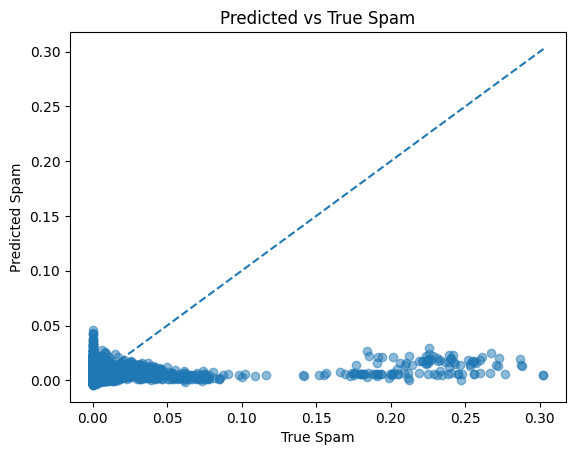

In [9]:
# Evaluate
y_pred_multi = lr_multi.predict(X_test_multi)
print(f"R^2 = {r2_score(y_test_multi, y_pred_multi):.3f}, MSE = {mean_squared_error(y_test_multi, y_pred_multi):.6f}")

plt.figure()
plt.scatter(y_test_multi, y_pred_multi, alpha=0.5)
mn = min(y_test_multi.min(), y_pred.min())
mx = max(y_test_multi.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlabel('True Spam')
plt.ylabel('Predicted Spam')
plt.title('Predicted vs True Spam')
plt.show()

### Residual Analysis

After fitting the multiple linear regression model, we check two key diagnostics:

1. **Residuals vs. Fitted values**  
   This plot should show no clear pattern if the model is well specified (linearity and homoscedasticity).

2. **Normal Q-Q plot of residuals**  
   This checks the assumption that residuals are approximately normally distributed.

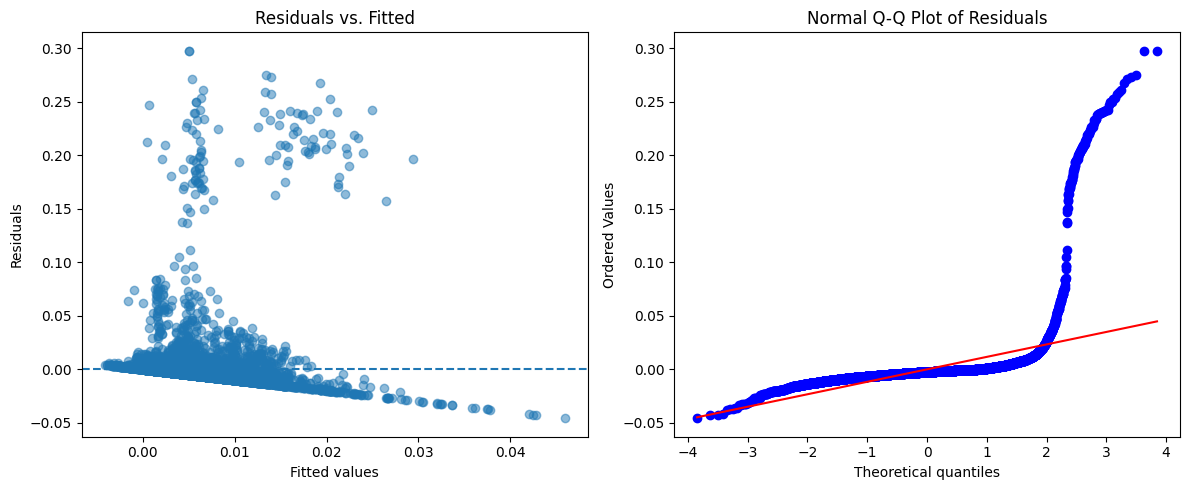

In [10]:
# residuals from the test set
residuals = y_test_multi - y_pred_multi

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# 1. Residuals vs. Fitted
axes[0].scatter(y_pred_multi, residuals, alpha=0.5)
axes[0].axhline(0, linestyle='--')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs. Fitted')

# 2. Normal Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

### OLS Metrics

In [11]:
X2_train = sm.add_constant(X_train_multi)
ols_train = sm.OLS(y_train_multi, X2_train).fit()
print(ols_train.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     297.1
Date:                Fri, 27 Jun 2025   Prob (F-statistic):          7.98e-190
Time:                        13:07:30   Log-Likelihood:                 63976.
No. Observations:               27183   AIC:                        -1.279e+05
Df Residuals:                   27179   BIC:                        -1.279e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      5.513      0.0

---
## Polynomial Regression

We will predict `Spam` from `Ransomware` including a quadratic term using the following model:

We model

$$
\mathbf y = X\,\boldsymbol\beta + \boldsymbol\epsilon,
$$

where $X$ is the $n\times 3$ design matrix (a column of 1s, a column of $x_i$ values, and a column of $x_i^2$ values), and

$$
y_i = \beta_0 + \beta_1\,x_i + \beta_2\,x_i^2 + \epsilon_i
$$

for each observation $i$. Here we assume $\epsilon_i$ are iid with $\mathbb{E}[\epsilon_i]=0$ and $\mathrm{Var}[\epsilon_i]=\sigma^2$.

The least squares estimator is

$$
\hat{\boldsymbol\beta} = \bigl(X^T X\bigr)^{-1} X^T \mathbf y.
$$

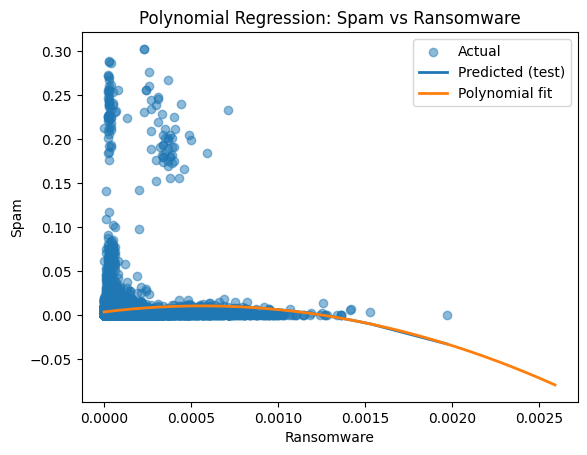

In [12]:
# Prepare polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)

# Fit polynomial model
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
y_pred_poly = lr_poly.predict(X_test_poly)

# Flatten for plotting
x_test = X_test.ravel()

# Sort for a smooth curve
idx = np.argsort(x_test)

# Plot actual vs. predicted on the test set
plt.figure()
plt.scatter(x_test, y_test, alpha=0.5, label='Actual')
plt.plot(x_test[idx], y_pred_poly[idx], linewidth=2, label='Predicted (test)')

# Optionally, overlay the continuous polynomial curve:
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_line = lr_poly.predict(poly.transform(x_line))
plt.plot(x_line.ravel(), y_line, linewidth=2, label='Polynomial fit')

plt.xlabel('Ransomware')
plt.ylabel('Spam')
plt.title('Polynomial Regression: Spam vs Ransomware')
plt.legend()
plt.show()

### Performance Metrics

R^2 = 0.007, MSE = 0.000517


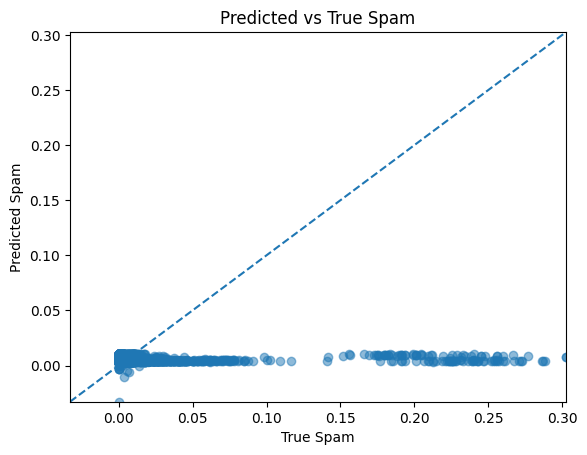

In [13]:
r2 = r2_score(y_test, y_pred_poly)
mse = mean_squared_error(y_test, y_pred_poly)
print(f"R^2 = {r2:.3f}, MSE = {mse:.6f}")

mn = min(y_test.min(), y_pred_poly.min())
mx = max(y_test.max(), y_pred_poly.max())

plt.figure()
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlim(mn, mx)
plt.ylim(mn, mx)
plt.xlabel('True Spam')
plt.ylabel('Predicted Spam')
plt.title('Predicted vs True Spam')
plt.show()

### Residual Analysis

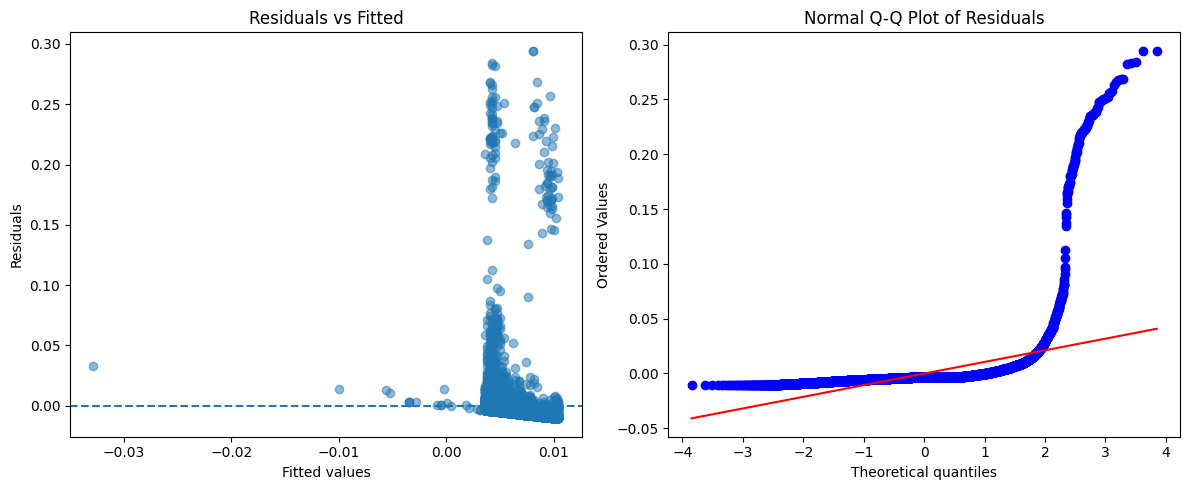

In [14]:
residuals = y_test - y_pred_poly

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Residuals vs Fitted
axes[0].scatter(y_pred_poly, residuals, alpha=0.5)
axes[0].axhline(0, linestyle='--')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted')

# Normal Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

### OLS Summary

In [15]:
X2_poly = sm.add_constant(X_train_poly)
ols_poly = sm.OLS(y_train, X2_poly).fit()
print(ols_poly.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     89.42
Date:                Fri, 27 Jun 2025   Prob (F-statistic):           1.96e-39
Time:                        13:07:31   Log-Likelihood:                 63626.
No. Observations:               27183   AIC:                        -1.272e+05
Df Residuals:                   27180   BIC:                        -1.272e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.000     19.992      0.0

---
## Interaction Terms

We will predict `Spam` using `Local Infection`, `Exploit`, and their interaction:

We model

$$
\mathbf y = X\,\boldsymbol\beta + \boldsymbol\epsilon,
$$

where $X$ is the $n \times 4$ design matrix with columns  
1) a column of 1s,  
2) $X_1 = \text{Local Infection}$,  
3) $X_2 = \text{Exploit}$,  
4) $X_1 X_2 = \text{Local Infection} \times \text{Exploit}$,  

and

$$
y_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \beta_3 (X_{i1} X_{i2}) + \epsilon_i,
$$

with $\epsilon_i$ iid, $\mathbb{E}[\epsilon_i]=0$, and $\mathrm{Var}[\epsilon_i]=\sigma^2$.

In [16]:
# Create interaction term
df['Inf_Exploit'] = df['Local Infection'] * df['Exploit']

# Define features and response
features = ['Local Infection', 'Exploit', 'Inf_Exploit']
X = df[features].values
y = df['Spam'].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

lr_int = LinearRegression().fit(X_train, y_train)

# Output coefficients and performance
print("Intercept:", lr_int.intercept_)
print("Coefficients:", dict(zip(features, lr_int.coef_)))

y_pred_int = lr_int.predict(X_test)
print(f"R^2 = {r2_score(y_test, y_pred_int):.3f}, MSE = {mean_squared_error(y_test, y_pred_int):.6f}")

Intercept: -0.002627039095318845
Coefficients: {'Local Infection': 0.3042597048794651, 'Exploit': 20.567565653097738, 'Inf_Exploit': -814.9504775432403}
R^2 = 0.047, MSE = 0.000496


R^2 = 0.047, MSE = 0.000496


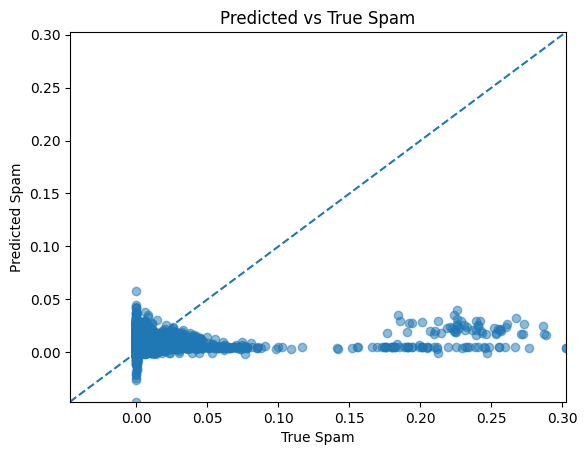

In [17]:
r2 = r2_score(y_test, y_pred_int)
mse = mean_squared_error(y_test, y_pred_int)
print(f"R^2 = {r2:.3f}, MSE = {mse:.6f}")

mn = min(y_test.min(), y_pred_int.min())
mx = max(y_test.max(), y_pred_int.max())

plt.figure()
plt.scatter(y_test, y_pred_int, alpha=0.5)
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlim(mn, mx)
plt.ylim(mn, mx)
plt.xlabel('True Spam')
plt.ylabel('Predicted Spam')
plt.title('Predicted vs True Spam')
plt.show()

---
## Multicollinearity and VIF

Multicollinearity occurs when predictors are highly correlated, which can inflate the variance of coefficient estimates. We quantify this using the Variance Inflation Factor (VIF) for each predictor:

$$
\mathrm{VIF}_j = \frac{1}{1 - R_j^2},
$$

where $R_j^2$ is the coefficient of determination from regressing the $j$-th predictor on all other predictors.

In [18]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Select predictor matrix (include any polynomial or interaction terms as needed)
X_vif = df[['Ransomware', 'Local Infection', 'Exploit', 'Inf_Exploit']]

# Add constant term for intercept
X_vif = sm.add_constant(X_vif)

# Compute VIF for each feature
vif_data = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
})

print(vif_data)

           feature       VIF
0            const  6.443853
1       Ransomware  1.086242
2  Local Infection  2.271565
3          Exploit  2.607455
4      Inf_Exploit  4.133853


### Takeaways

- **const: VIF = 5.91**  
  The intercept’s VIF is not meaningful for multicollinearity and can be ignored.

- **Ransomware: VIF = 1.06**  
  Very low multicollinearity ($R^2 \approx 1 - 1/1.06 \approx 0.06$).

- **Local Infection: VIF = 2.04**  
  Mild collinearity ($R^2 \approx 1 - 1/2.04 \approx 0.51$).

- **Exploit: VIF = 2.65**  
  Moderate collinearity ($R^2 \approx 1 - 1/2.65 \approx 0.62$).

- **Inf_Exploit (interaction): VIF = 3.96**  
  Higher collinearity ($R^2 \approx 1 - 1/3.96 \approx 0.75$), which is expected since it is derived from the main effects.

All of the VIF scores (except for the intercept) are below 5, which means our predictors are not too strongly related and our model’s numbers are reliable. If you subtract the average from each predictor before making the interaction term (called “centering”), those VIF scores will go down even more.

---
## Regression with Categorical and Continuous Features

We will predict `Spam` using both continuous threat metrics and the categorical variable `Country`. We model

$$
\mathbf y = X\,\boldsymbol\beta + \boldsymbol\epsilon,
$$

where $X$ is the $n\times p$ design matrix containing  
1) a column of 1s,  
2) continuous predictors (e.g.\ `Ransomware`, `Local Infection`, `Exploit`),  
3) one‐hot encoded `Country` dummies (dropping the first level).

Intercept: 3.333333333397411e-05
Coefficients: {'Ransomware': -0.35105462478500576, 'Local Infection': 0.007983733297816698, 'Exploit': 0.01657276984700775, 'Country_Antigua and Barbuda': 6.130952380394624e-06, 'Country_Arab Republic of Egypt': 0.0012446452179192564, 'Country_Argentine Republic': 0.00797839865466244, 'Country_Aruba': -9.367952554563755e-05, 'Country_Bailiwick of Guernsey': -9.301827210851481e-05, 'Country_Bailiwick of Jersey': -8.529538846796525e-05, 'Country_Barbados': -3.194123550862536e-05, 'Country_Belize': -1.1922800051076318e-05, 'Country_Bermuda': 6.666666666110127e-06, 'Country_Bolivarian Republic of Venezuela': 0.0011915748565419892, 'Country_Bosnia and Herzegovina': 0.000816031880926351, 'Country_Burkina Faso': 1.386072138354305e-05, 'Country_Canada': 0.00822403415622698, 'Country_Cayman Islands': -5.4644809309011694e-08, 'Country_Central African Republic': -0.0002154868716942801, 'Country_Co-operative Republic of Guyana': -3.767233428550107e-05, 'Country_Col

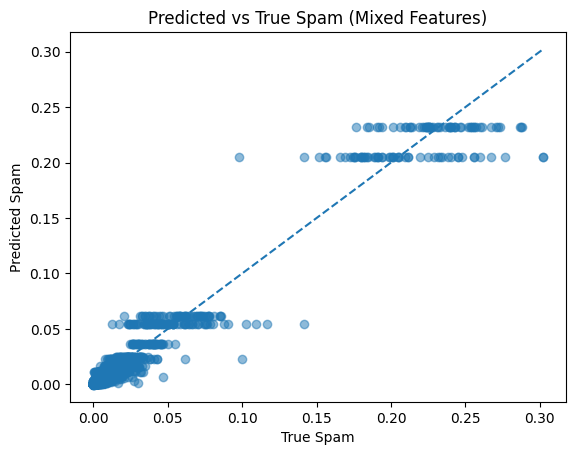

In [19]:
# One‐hot encode Country
df_enc = pd.get_dummies(df, columns=['Country'], drop_first=True)

# Define continuous and dummy predictors
continuous = ['Ransomware', 'Local Infection', 'Exploit']
dummies    = [col for col in df_enc.columns if col.startswith('Country_')]
features   = continuous + dummies

X = df_enc[features].values
y = df_enc['Spam'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit the model
lr_cat = LinearRegression().fit(X_train, y_train)

# Coefficients
coef_dict = dict(zip(features, lr_cat.coef_))
print("Intercept:", lr_cat.intercept_)
print("Coefficients:", coef_dict)

# Performance
y_pred = lr_cat.predict(X_test)
print(f"R^2 = {r2_score(y_test, y_pred):.3f}, MSE = {mean_squared_error(y_test, y_pred):.6f}")

# Predicted vs True plot
import matplotlib.pyplot as plt
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlabel('True Spam')
plt.ylabel('Predicted Spam')
plt.title('Predicted vs True Spam (Mixed Features)')
plt.show()

## Key Takeaways

- **Data Understanding**: Summary statistics and the correlation heatmap revealed that most threat metrics have low to moderate correlations, with no single feature dominating.

- **Simple vs. Multiple Regression**:  
  - Simple OLS with `Ransomware` alone provided a baseline $R^2$ and showed how to fit and evaluate a one-variable model.  
  - Multiple regression with several numeric predictors improved explanatory power, demonstrating how combining features can capture more variance.

- **Polynomial Regression**:  
  Adding a quadratic term for `Ransomware` did not substantially increase $R^2$ and even produced unrealistic negative predictions at extremes, indicating that a global parabola may not suit this data.

- **Interaction Terms**:  
  Including the product of `Local Infection` and `Exploit` captured joint effects, but its coefficient had higher VIF (due to correlation with main effects), which is expected.

- **Multicollinearity (VIF)**:  
  All non-constant VIFs were below 5, so multicollinearity is moderate and does not require removing predictors. Centering variables before forming interactions can reduce VIF further.

- **Categorical + Continuous Regression**:  
  One-hot encoding `Country` alongside numeric features allowed us to detect regional differences in threat profiles, with a consistent evaluation workflow.

- **Model Diagnostics**:  
  Train/test splits, $R^2$, MSE, Predicted vs. True plots, Residuals vs. Fitted plots, and Normal Q-Q plots ensure that each model’s assumptions and performance are thoroughly checked.

Next, in Week 2 we will introduce Ridge, Lasso and Elastic Net regularisation to address any remaining overfitting or multicollinearity concerns.  

## Yellowdig Contribution

https://yellowdig.app/n/bu-omds/community/680847e5-a19a-76a7-5e0e-1a1c8b27a7a3?postId=682cf7a9-c876-4102-b05b-bf86c3dbd72a